Connecting to the database and importing the relevant libraries

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from src import AMADEUS_API
from pymongo import MongoClient

client = MongoClient("mongodb://localhost/companies")
db = client.get_database()

We have priorized the fact that the new office must be nearby other companies that also do design. That is the most demanding requirement and therefore, must be the first one.

First, we are goint to check in our database which kind of companys are interesting to us.

In [60]:
category_codes=list(db.companies.distinct("category_code",{}))

print(category_codes)

[None, 'advertising', 'analytics', 'automotive', 'biotech', 'cleantech', 'consulting', 'design', 'ecommerce', 'education', 'enterprise', 'fashion', 'finance', 'games_video', 'government', 'hardware', 'health', 'hospitality', 'legal', 'local', 'manufacturing', 'medical', 'messaging', 'mobile', 'music', 'nanotech', 'network_hosting', 'news', 'nonprofit', 'other', 'photo_video', 'public_relations', 'real_estate', 'search', 'security', 'semiconductor', 'social', 'software', 'sports', 'transportation', 'travel', 'web']


For our purpose, companies dedicated to videogames (games_video), hardware, mobile, software, and web are interesting, so we are goint to obtain all the information of the companies matching this tags.

In [61]:
interesting_companies=list(db.companies.find({"$or":[{"category_code":{"$eq":"games_video"}},{"category_code":{"$eq":"software"}},{"category_code":{"$eq":"mobile"}},{"category_code":{"$eq":"software"}},{"category_code":{"$eq":"web"}}]},{"offices":1,"name":1,"category_code":1}))

In [62]:
#First we structure the information in dictionarys

company_data=[
   [
        
    {
    "name":element["name"],
    "id":element["_id"],
    "category_code":element["category_code"],
    "address1":offices["address1"],
    "address2":offices["address2"],
    "city":offices["city"],
    "country_code":offices["country_code"],
    "description":offices["description"],
    "latitude":offices["latitude"],
    "longitude":offices["longitude"],
    "state_code":offices["state_code"],
    "zip_code":offices["zip_code"]
    } 
  
for offices in element["offices"]]
              
              for element in interesting_companies]



#Now we flatten the list using another list comprehension

company_data=[office for empresas in company_data for office in empresas]


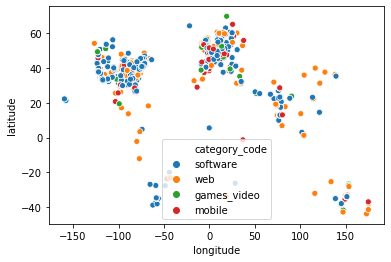

In [63]:
df=pd.DataFrame(company_data).dropna(subset=["longitude","latitude"])
sns.scatterplot(x="longitude",y="latitude",data=df,hue="category_code")

We are going to limit the search to the United States

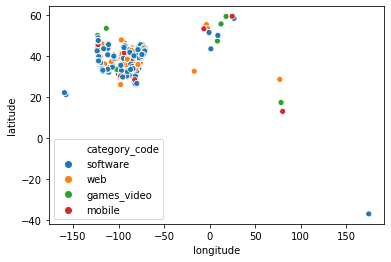

In [64]:
df=df.loc[df.country_code=="USA"]

sns.scatterplot(x="longitude",y="latitude",data=df,hue="category_code");

We crearly see that some offices are not well labeles, so we get rid of them by hand.

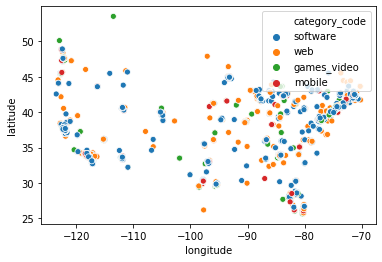

In [65]:
df=df.loc[df.longitude<-50]
df=df.loc[df.longitude>-150]
sns.scatterplot(x="longitude",y="latitude",data=df,hue="category_code");

By plotting the coordinates of all offices that are interesting for us, we clearly see different clusters with some disperse points. We are going to use KMeans method, not to predict (because that is not what we are aiming to) but to make some calculations on each cluster.

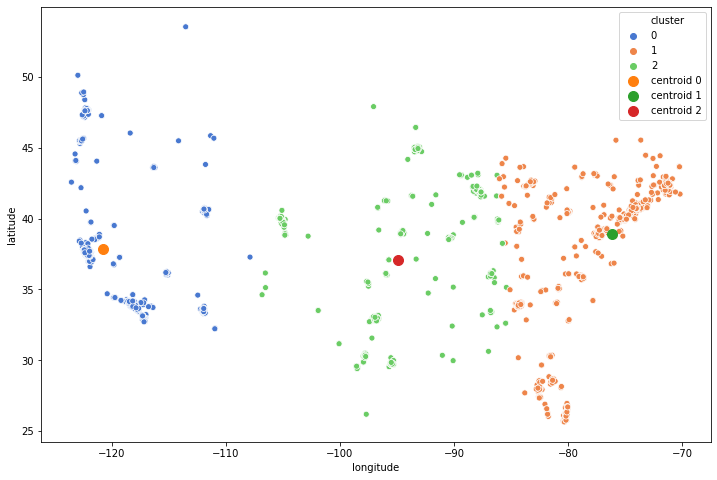

In [66]:
from sklearn.cluster import KMeans

X = np.array([df.longitude,df.latitude]).T

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
df['cluster']=kmeans.predict(X)

cluster_centers=kmeans.cluster_centers_


plt.figure(figsize=(12,8))

sns.scatterplot(x="longitude",y="latitude",data=df ,hue="cluster",palette="muted")

plt.scatter(cluster_centers[0][0],cluster_centers[0][1],s=100,label="centroid 0")
plt.scatter(cluster_centers[1][0],cluster_centers[1][1],s=100,label="centroid 1")
plt.scatter(cluster_centers[2][0],cluster_centers[2][1],s=100,label="centroid 2")
plt.legend();


We are going to see the centroid of each cluster in a real map to make it more clear.

In [67]:

m = folium.Map(location=[cluster_centers[2][1],cluster_centers[2][0]],zoom_start=4.2,no_touch=True)
list(cluster_centers[0])
folium.Marker([cluster_centers[0][1],cluster_centers[0][0]],popup="Cluster 0 centroid").add_to(m)
folium.Marker([cluster_centers[1][1],cluster_centers[1][0]],popup="Cluster 1 centroid").add_to(m)
folium.Marker([cluster_centers[2][1],cluster_centers[2][0]],popup="Cluster 2 centroid").add_to(m)
m

In the map, we see that the center of our centroids corresponds to the East Coast, the Middle West and the Pacific Coast. We are going to work with the offices in the cluster of the East Coast, due to its connections to Europe.

Also, we are going to limit our search to states that have at least 100 tech-related companies.

In [68]:
df=df.loc[df.cluster==1] 

data_NY=df[df.state_code=="NY"]
data_FO=df[df.state_code=="FL"]
data_MA=df[df.state_code=="MA"]

In [69]:
X_NY = np.array([data_NY.longitude,data_NY.latitude]).T

kmeans_NY = KMeans(n_clusters=1)
kmeans_NY.fit(X_NY)
cluster_centers_NY=kmeans_NY.cluster_centers_
m1 = folium.Map(location=[cluster_centers_NY[0][1],cluster_centers_NY[0][0]],zoom_start=12,no_touch=True)
folium.Marker([cluster_centers_NY[0][1],cluster_centers_NY[0][0]],popup="Cluster 0 centroid").add_to(m1)

m1


In [70]:
X_MA = np.array([data_MA.longitude,data_MA.latitude]).T

kmeans_MA = KMeans(n_clusters=1)
kmeans_MA.fit(X_MA)
cluster_centers_MA=kmeans_MA.cluster_centers_
m1 = folium.Map(location=[cluster_centers_MA[0][1],cluster_centers_MA[0][0]],zoom_start=12,no_touch=True)
folium.Marker([cluster_centers_MA[0][1],cluster_centers_MA[0][0]],popup="Cluster 0 centroid").add_to(m1)

m1


In [71]:
X_FO = np.array([data_FO.longitude,data_FO.latitude]).T

kmeans_FO = KMeans(n_clusters=1)
kmeans_FO.fit(X_FO)
cluster_centers_FO=kmeans_FO.cluster_centers_
m1 = folium.Map(location=[cluster_centers_FO[0][1],cluster_centers_FO[0][0]],zoom_start=12,no_touch=True)
folium.Marker([cluster_centers_FO[0][1],cluster_centers_FO[0][0]],popup="Cluster 0 centroid").add_to(m1)

m1


So we have three probable locations for our office that are surrounded by tech-related companies. We are going to check other requeriments.

First we are going to check another important requirement: 

In [72]:
AMADEUS_API.closest_airport(cluster_centers_NY[0][1],cluster_centers_NY[0][0]);
AMADEUS_API.closest_airport(cluster_centers_MA[0][1],cluster_centers_MA[0][0]);
AMADEUS_API.closest_airport(cluster_centers_FL[0][1],cluster_centers_FL[0][0]);

In [73]:
cluster_centers_NY[0][1]

40.8397717643617

In [ ]:
centroid_dict_lat = {0:cluster_centers[0][0],1:cluster_centers[1][0]}
centroid_dict_lon = {0:cluster_centers[0][1],1:cluster_centers[1][1]}
df["centroid_lat"] = df.cluster.map(centroid_dict_lat)
df["centroid_lon"]=df.cluster.map(centroid_dict_lon)

df["distance"]=((df.latitude-df.centroid_lat)**2+(df.longitude-df.centroid_lon)**2)**(1/2)

mean_distance=[df.distance.loc[df.cluster==0].mean(),df.distance.loc[df.cluster==1].mean()]

std_distance=[df.distance.loc[df.cluster==0].std(),df.distance.loc[df.cluster==1].std()]

df["mean_distance"]=df.cluster.map(lambda x: mean_distance[x])
df["std_mean_distance"]=df.cluster.map(lambda x: std_distance[x])


df=df.loc[df.distance<=df.mean_distance+2*df.std_mean_distance]
df=df.loc[df.distance>=df.mean_distance-2*df.std_mean_distance]